### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import StringIO

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
download_link = 'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'
# see https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
# new source https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [4]:
req = requests.get(download_link)
rki_raw = pd.read_csv(StringIO(req.text))

In [5]:
rki_raw.tail()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
132782,5806838,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2020/04/22 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,-9,2020/04/17 00:00:00,0,1,1,Nicht übermittelt
132783,5806839,16,Thüringen,LK Altenburger Land,A80+,M,1,1,2020/03/24 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,0,2020/03/16 00:00:00,-9,0,1,Nicht übermittelt
132784,5806840,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/03/27 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,-9,2020/03/23 00:00:00,0,1,1,Nicht übermittelt
132785,5806841,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/05/07 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,-9,2020/05/05 00:00:00,-9,0,1,Nicht übermittelt
132786,5806842,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2020/05/06 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,-9,2020/05/04 00:00:00,-9,0,1,Nicht übermittelt


In [6]:
def new_cases_by_date(rki_raw, rki_flag_column='Neuer Fall', rki_count_columns='AnzahlFall'):
    """
    rki_raw: raw DataFrame from Robert Koch Institute
    """
    condition = rki_raw[rki_flag_column].isin((0, 1))
    rki_series = rki_raw[condition].groupby('Refdatum').sum()[rki_count_columns].copy()
    rki_series.index = pd.to_datetime(rki_series.index)
    rki_series.sort_index(inplace=True)
    return rki_series

In [7]:
rki_cases = new_cases_by_date(rki_raw, rki_flag_column='NeuerFall', rki_count_columns='AnzahlFall')
rki_death = new_cases_by_date(rki_raw, rki_flag_column='NeuerTodesfall', rki_count_columns='AnzahlTodesfall')
rki_recovered = new_cases_by_date(rki_raw, rki_flag_column='NeuGenesen', rki_count_columns='AnzahlGenesen')

In [8]:
rki = pd.concat([rki_cases, rki_death, rki_recovered], axis=1, sort=True)
columns_dict = {'AnzahlFall': 'NewCases', 'AnzahlTodesfall': 'NewDeath', 'AnzahlGenesen': 'NewRecovered'}
rki.rename(columns_dict, axis=1, inplace=True)
rki['NewRecovered'] = rki.NewCases.shift(14).fillna(0)  # better estimate than official numbers..
rki.fillna(value=0., inplace=True)
rki.tail()

,NewCases,NewDeath,NewRecovered
Refdatum,,,
2020-05-05,735,8.0,1565.0
2020-05-06,739,3.0,1726.0
2020-05-07,646,1.0,1619.0
2020-05-08,545,1.0,1473.0
2020-05-09,246,0.0,1139.0


In [9]:
rki['Cases'] = rki['NewCases'].cumsum()
rki['Death'] = rki['NewDeath'].cumsum()
rki['Recovered'] = rki['NewRecovered'].cumsum()
rki['ActiveCases'] = rki['Cases'] - rki['Recovered']
rki['Growth'] = rki['NewCases'] / rki['ActiveCases']
rki.tail(10)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Refdatum,,,,,,,,
2020-04-30,1087,16.0,2232.0,163863,7349.0,144317.0,19546.0,0.055612
2020-05-01,737,13.0,2283.0,164600,7362.0,146600.0,18000.0,0.040944
2020-05-02,592,3.0,1654.0,165192,7365.0,148254.0,16938.0,0.034951
2020-05-03,482,7.0,1329.0,165674,7372.0,149583.0,16091.0,0.029955
2020-05-04,633,10.0,1655.0,166307,7382.0,151238.0,15069.0,0.042007
2020-05-05,735,8.0,1565.0,167042,7390.0,152803.0,14239.0,0.051619
2020-05-06,739,3.0,1726.0,167781,7393.0,154529.0,13252.0,0.055765
2020-05-07,646,1.0,1619.0,168427,7394.0,156148.0,12279.0,0.052610
2020-05-08,545,1.0,1473.0,168972,7395.0,157621.0,11351.0,0.048013


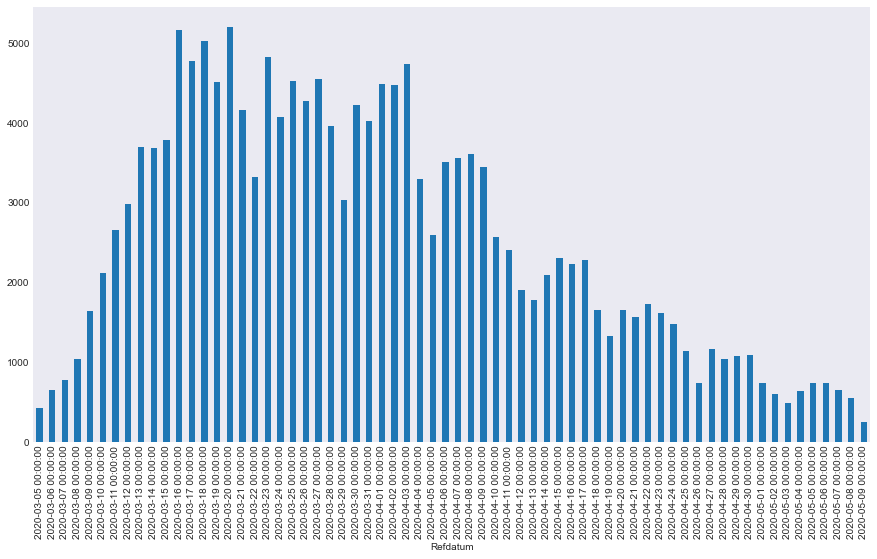

In [10]:
rki.NewCases['03-05-2020':].plot.bar()

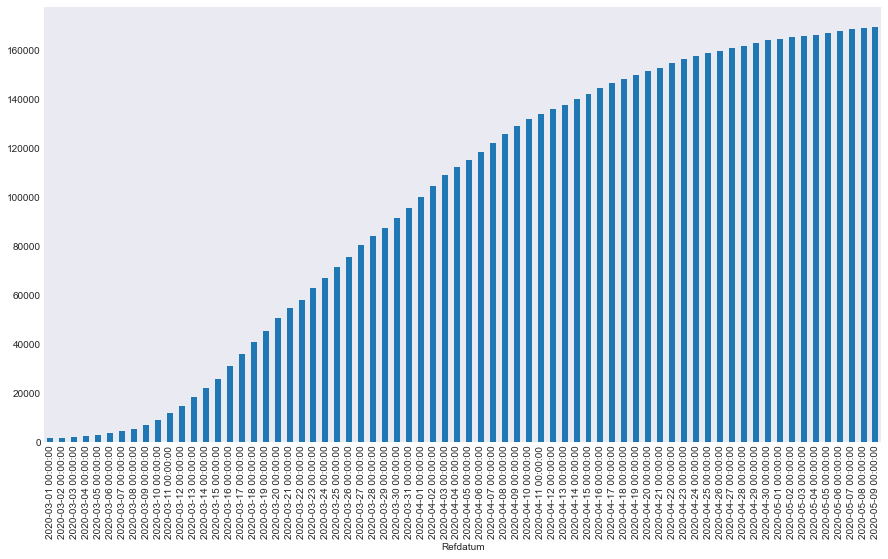

In [11]:
rki.Cases['03-01-2020':].plot.bar()

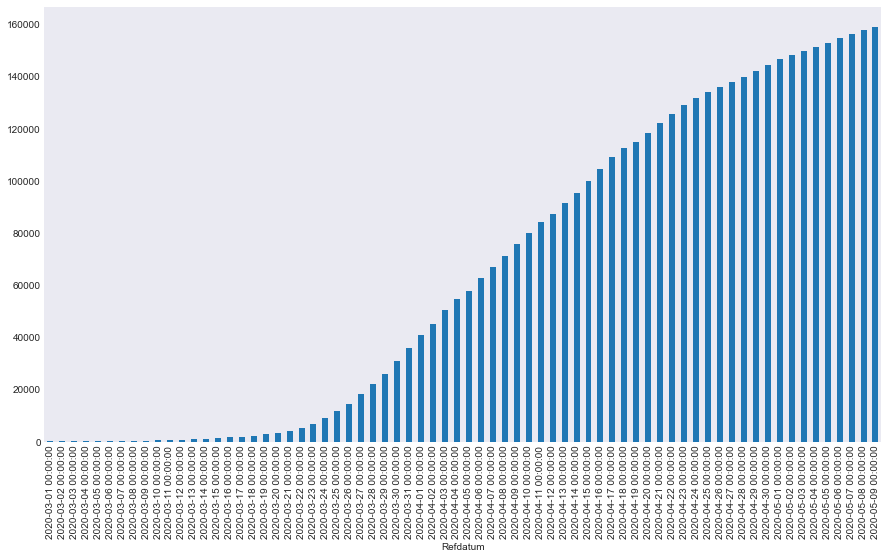

In [12]:
rki.Recovered['03-01-2020':].plot.bar()

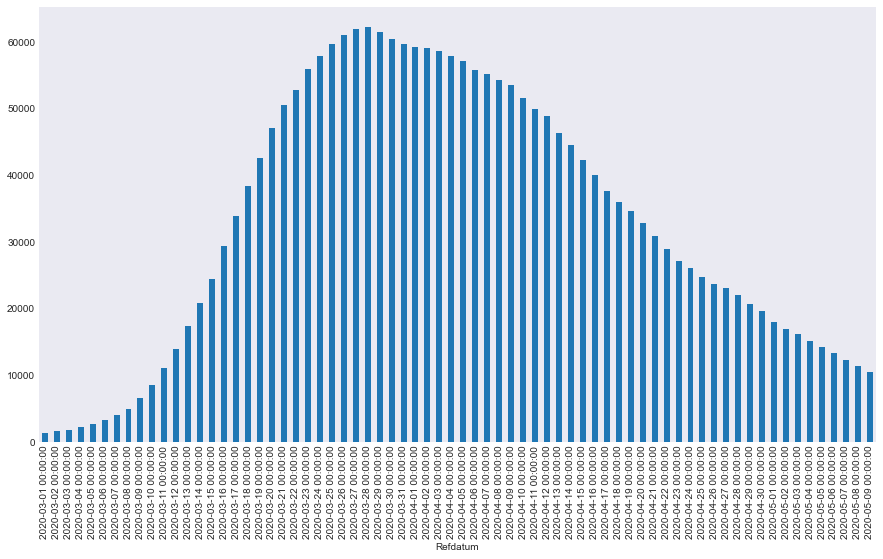

In [13]:
rki.ActiveCases['03-01-2020':].plot.bar()

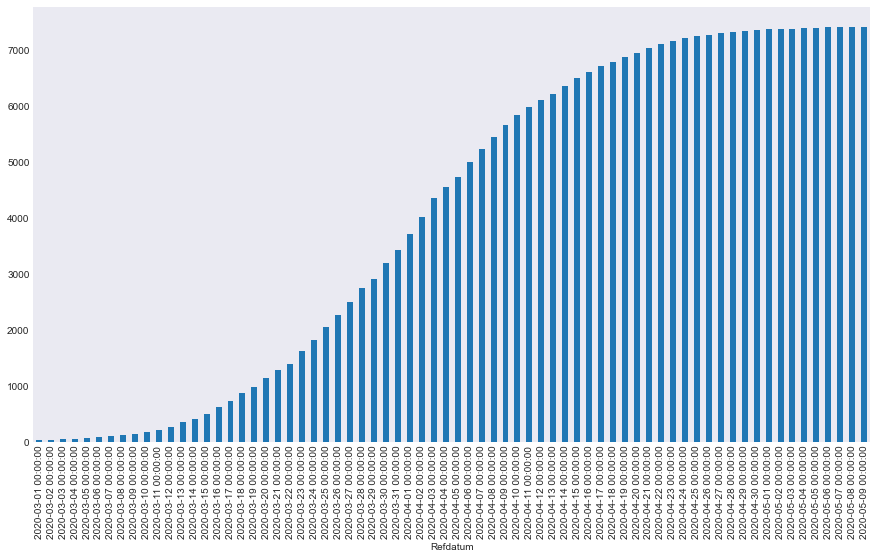

In [14]:
rki.Death['03-01-2020':].plot.bar()

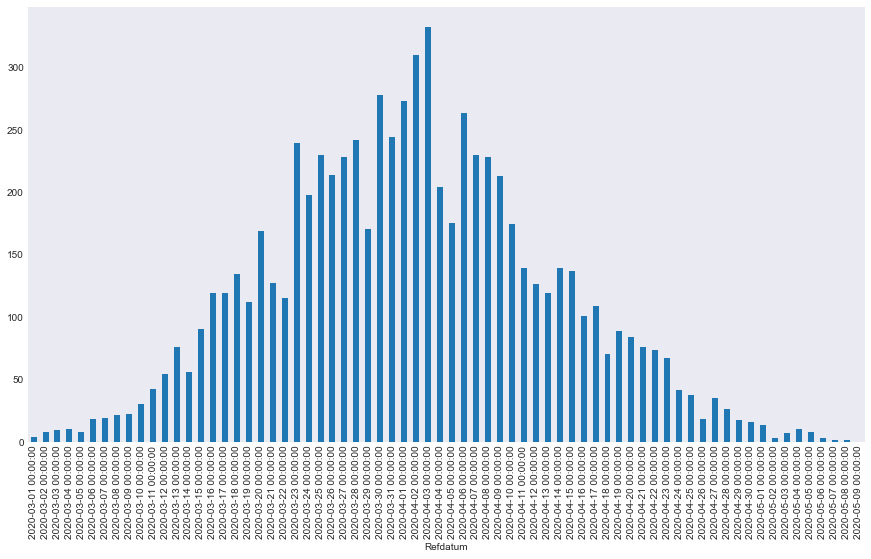

In [15]:
rki.NewDeath['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'Growth Germany')

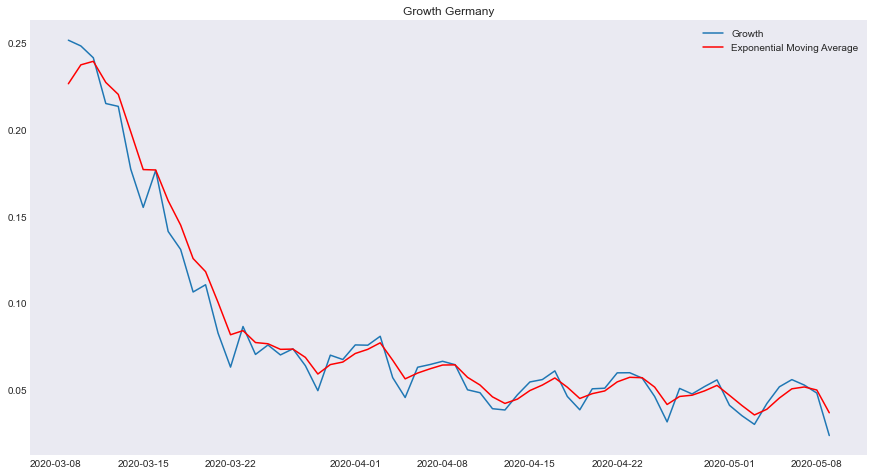

In [16]:
start_date = '03-09-2020'
x = rki[start_date:].index
plt.plot(x, rki.Growth[start_date:], label='Growth')
plt.plot(x, rki.Growth.ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

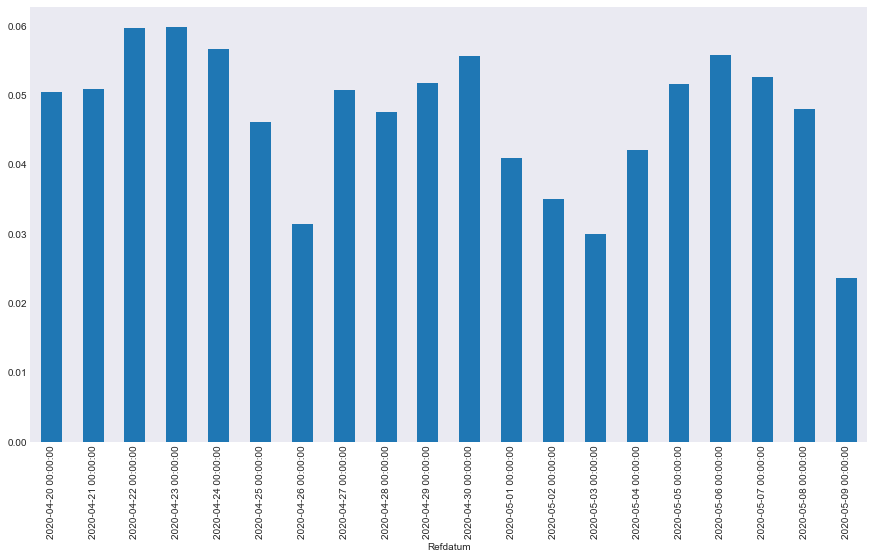

In [17]:
rki.Growth['04-20-2020':].plot.bar()

Text(0.5, 1.0, 'New Cases Germany')

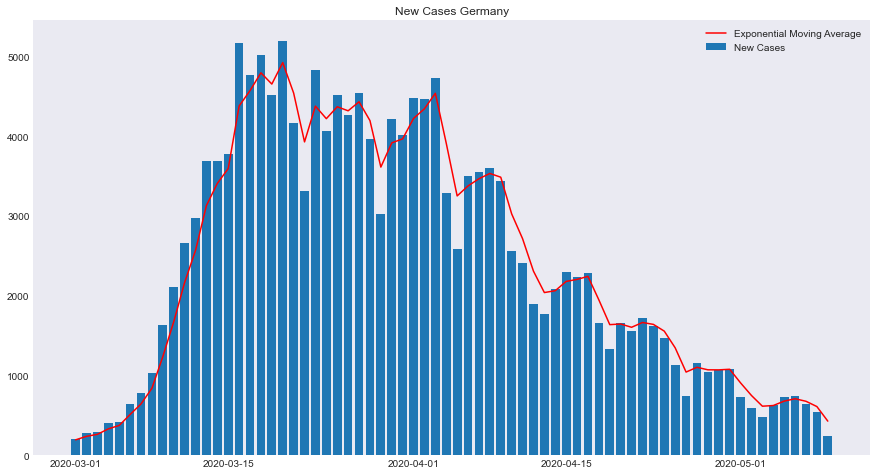

In [18]:
start_date = '03-01-2020'
x = rki[start_date:].index

plt.bar(x, rki.NewCases[start_date:], label='New Cases')
plt.plot(x, rki.NewCases.ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('New Cases Germany')

In [19]:
rki.tail(20)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Refdatum,,,,,,,,
2020-04-20,1655,84.0,3505.0,151238,6943.0,118443.0,32795.0,0.050465
2020-04-21,1565,76.0,3560.0,152803,7019.0,122003.0,30800.0,0.050812
2020-04-22,1726,73.0,3602.0,154529,7092.0,125605.0,28924.0,0.059674
2020-04-23,1619,67.0,3442.0,156148,7159.0,129047.0,27101.0,0.059739
2020-04-24,1473,41.0,2569.0,157621,7200.0,131616.0,26005.0,0.056643
2020-04-25,1139,37.0,2407.0,158760,7237.0,134023.0,24737.0,0.046044
2020-04-26,740,18.0,1903.0,159500,7255.0,135926.0,23574.0,0.031391
2020-04-27,1164,35.0,1773.0,160664,7290.0,137699.0,22965.0,0.050686
2020-04-28,1041,26.0,2088.0,161705,7316.0,139787.0,21918.0,0.047495
